# Importaciones para el proyecto:

In [1]:
import sys
import os
print(os.getcwd())
sys.path.append(os.path.abspath("../"))

c:\Users\lukat\BOOTCAMPASUS\ML_Adidas-Forecast\src\notebooks


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import utils.bootcampviztools as bt
import utils.toolbox_ML as tb
import utils.funciones_eda as fe

Paquete utils cargado correctamente


# ✅ Step 1: Objetivo del proyecto.


### ADIDAS Y SUS DISTRIBUIDORES EN UNITED STATES. 🔎

Adidas quiere saber una predicción razonable de cuánto facturarán las tiendas distribuidoras para asi saber si los productos que solicitan son adecuados a su nivel de facturación. Es muy importante que el producto esté en el lugar más eficiente posible y para ello debemos predecirlo.

A su vez, quieren plantear un sistema logístico para los Estados de USA donde haya más demanda de producto. Considerando asi una prevención a la rotura de stock y a la mejora en costes ya que el producto más vendido en cada Estado estaría más cerca de dichas tiendas distribuidoras.

🤔 PREGUNTAS QUE NOS HACEMOS 🤔

A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS 💵
- ¿Qué mercado es el que está en auge para estos años?
- ¿Hay algún mercado que debamos conocer que vaya en declive?
- ¿Cumplirán las tiendas con el mínimo de facturación deseable?
- ¿Varía la facturación con la estacionalidad?

B. PREVENCIÓN A LA ROTURA DE STOCK Y MEJORA EN COSTES 🚛
- ¿En qué regiones debemos tener un centro logístico más potente para el futuro?
- ¿Cuánto stock por categoría deberá estar disponible en cada región?

# ✅ Step 2: Obtener datos.


In [3]:
file_path = "../data/adidas_sales.csv"

In [4]:
df = pd.read_csv(file_path)
df.head(5)

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Sales Method
0,Walmart,1128299,6/17/2021,Southeast,Florida,Orlando,Women's Apparel,$103.00,218,"2,245","$1,257",Online
1,West Gear,1128299,7/16/2021,South,Louisiana,New Orleans,Women's Apparel,$103.00,163,"1,679",$806,Online
2,Sports Direct,1197831,8/25/2021,South,Alabama,Birmingham,Men's Street Footwear,$10.00,700,"7,000","$3,150",Outlet
3,Sports Direct,1197831,8/27/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,575,"8,625","$3,881",Outlet
4,Sports Direct,1197831,8/21/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,475,"7,125","$3,206",Outlet


---------
A simple vista vemos:
- Columnas espaciadas.
- Error en el cálculo de ***"Total Sales"***
- Columnas que vamos a limpiar para tener el DataFrame lo más funcional posible.

Y más cosas que veremos en el siguiente paso

# ✅ Step 3: Limpieza de datos - Correcciones - Nuevos datasets.


- Solucionamos las columnas espaciadas:

In [5]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   retailer          9641 non-null   object
 1   retailer_id       9641 non-null   int64 
 2   invoice_date      9641 non-null   object
 3   region            9641 non-null   object
 4   state             9641 non-null   object
 5   city              9641 non-null   object
 6   product           9641 non-null   object
 7   price_per_unit    9639 non-null   object
 8   units_sold        9641 non-null   object
 9   total_sales       9641 non-null   object
 10  operating_profit  9641 non-null   object
 11  sales_method      9641 non-null   object
dtypes: int64(1), object(11)
memory usage: 904.0+ KB


- Valores faltantes en ***"price_per_unit"*** pero antes solucionaremos el error de cálculo en ***"total_sales"***
- Tenemos tipo object en todas las columnas, debemos transformar a númericas algunas.
- Queremos transformar ***"invoice_date"*** en datetime.
- Vamos a eliminar columnas no relevantes al proyecto.

In [7]:
df.sample(1)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
6502,Foot Locker,1185732,2/8/2021,Northeast,Rhode Island,Providence,Women's Athletic Footwear,$20.00,16,32,$14,Outlet


- Si vemos el *sample* podemos ver que la multiplicación en ***"total_sales"*** (*price_per_unit* y *units_sold*) no es correcta. Vamos a hacerla de nuevo y corregiremos el símbolo del dollar. La haremos tipo numérica. Por último añadiremos dos decimales en las columnas.

In [8]:
df["price_per_unit"] = df["price_per_unit"].str.replace("$", "")
df["price_per_unit"] = pd.to_numeric(df["price_per_unit"], errors="coerce")

In [9]:
# Visión general de los datos
df.sample(6)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
426,West Gear,1128299,8/17/2021,South,Louisiana,New Orleans,Men's Athletic Footwear,57.0,256,"1,459",$642,Outlet
5572,Foot Locker,1185732,6/17/2021,Midwest,Illinois,Chicago,Women's Apparel,45.0,63,284,$179,Online
4931,Sports Direct,1185732,12/6/2021,Northeast,New Jersey,Newark,Men's Apparel,55.0,83,457,$205,Online
9626,Sports Direct,1185732,10/5/2021,Northeast,Connecticut,Hartford,Women's Street Footwear,55.0,175,"9,625","$2,888",In-store
7882,Sports Direct,1197831,7/29/2020,South,Texas,Houston,Men's Apparel,NaN,500,"20,000","$6,000",Outlet
9551,Foot Locker,1128299,9/25/2021,Southeast,Virginia,Richmond,Women's Athletic Footwear,50.0,200,"10,000","$3,500",In-store


In [10]:
df["units_sold"] = pd.to_numeric(df["units_sold"].str.replace(",", ""),errors="coerce")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9639 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   object 
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 904.0+ KB


Siendo columnas numéricas ya podríamos calcular el correcto "total_sales" pero vamos a visualizar los nulos primero antes de tocar los datos.

In [12]:
df[df.isnull().any(axis=1)]

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
6725,Foot Locker,1185732,1/29/2020,Northeast,New York,New York,Men's Apparel,NaN,850,"51,000","$15,300",Outlet
7882,Sports Direct,1197831,7/29/2020,South,Texas,Houston,Men's Apparel,NaN,500,"20,000","$6,000",Outlet


---------
🤔 Esto seria una pregunta para "Negocio" porque tenemos dos soluciones para afrontar estos nulos.
1. Entendemos que la división de ***"total_sales"*** / ***"units_sold"*** dan el resultado de ***"price_per_unit"***
2. Hemos visto que hay valores de ***"total_sales"*** que no fueron bien calculados y todos tienen en común la falta del último dígito.

Ya que son dos valores faltantes, vamos a confiar en los valores que tenemos del dataset y haremos la opción 1

In [13]:
df["total_sales"] = pd.to_numeric(df["total_sales"].str.replace(",", ""),errors="coerce")


In [14]:
df["price_per_unit"] = df["price_per_unit"].fillna(df["total_sales"] / df["units_sold"])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9641 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   int64  
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 904.0+ KB


- Calculamos los valores correctos de ***"total_sales"***

In [16]:
df['total_sales'] = df['price_per_unit'] * df['units_sold']

In [17]:
df.sample(5)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
1498,Kohl's,1189833,5/6/2021,West,California,Los Angeles,Women's Apparel,61.0,189,11529.0,$404,Online
4720,West Gear,1185732,10/12/2021,Northeast,Vermont,Burlington,Women's Apparel,54.0,90,4860.0,$224,Outlet
400,Foot Locker,1185732,1/26/2020,Northeast,New York,New York,Men's Athletic Footwear,48.0,259,12432.0,$535,Online
1926,West Gear,1128299,2/17/2021,West,Oregon,Portland,Men's Street Footwear,24.0,175,4200.0,$189,Outlet
4431,West Gear,1185732,5/12/2021,West,Utah,Salt Lake City,Women's Street Footwear,25.0,98,2450.0,$123,Online


In [18]:
# Eliminamos las filas con resultado 0 en total_sales
df = df[df["total_sales"] != 0]

- DateTime para ***"invoice_date"*** y ordenamos el DataFrame

In [19]:
df["invoice_date"] = pd.to_datetime(df["invoice_date"])

In [20]:
df = df.sort_values(by="invoice_date")
df.head(8)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
9189,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0,"$6,188",Outlet
4937,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0,$141,Outlet
30,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0,$679,Outlet
4908,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0,$243,Online
79,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,47.0,336,15792.0,$963,Online
6562,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,60000.0,"$30,000",In-store
6588,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,50000.0,"$15,000",In-store
117,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,36.0,320,11520.0,$403,Outlet


In [21]:
df.isnull().sum()

retailer            0
retailer_id         0
invoice_date        0
region              0
state               0
city                0
product             0
price_per_unit      0
units_sold          0
total_sales         0
operating_profit    0
sales_method        0
dtype: int64

- Eliminamos columnas irrelevantes y hacemos una copia de seguridad del dataset

In [22]:
df = df.drop(columns=["retailer_id", "operating_profit", "sales_method"])

# "operation_profit" se elimina porque no tenemos contexto sobre los gastos para entender realmente el profit

- Una vista rápida para saber si está todo en orden

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9637 entries, 9189 to 9605
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9637 non-null   object        
 1   invoice_date    9637 non-null   datetime64[ns]
 2   region          9637 non-null   object        
 3   state           9637 non-null   object        
 4   city            9637 non-null   object        
 5   product         9637 non-null   object        
 6   price_per_unit  9637 non-null   float64       
 7   units_sold      9637 non-null   int64         
 8   total_sales     9637 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 752.9+ KB


In [24]:
df.region.value_counts()

region
West         2446
Northeast    2376
Midwest      1865
South        1726
Southeast    1224
Name: count, dtype: int64

In [25]:
df.state.value_counts()

state
Texas             430
California        430
Florida           360
New York          360
Pennsylvania      216
Arkansas          216
Oklahoma          216
Rhode Island      216
Oregon            216
Virginia          216
Vermont           216
Mississippi       216
Idaho             216
Utah              216
New Hampshire     216
Arizona           216
Tennessee         216
Massachusetts     216
New Mexico        216
Alabama           216
Nevada            216
Connecticut       216
Georgia           216
Louisiana         216
Kentucky          144
Colorado          144
Washington        144
West Virginia     144
Wyoming           144
Minnesota         144
Montana           144
Iowa              144
Ohio              144
North Dakota      144
Alaska            144
Wisconsin         144
Michigan          144
Maryland          144
New Jersey        144
Indiana           144
Hawaii            144
South Dakota      144
Maine             144
North Carolina    144
Kansas            144
Miss

In [26]:
df.city.value_counts()

city
Portland          360
Charleston        288
Little Rock       216
New York          216
Boston            216
Oklahoma City     216
Providence        216
Richmond          216
Burlington        216
Philadelphia      216
Orlando           216
Jackson           216
Salt Lake City    216
Manchester        216
Phoenix           216
Los Angeles       216
Knoxville         216
Birmingham        216
Boise             216
Albuquerque       216
Dallas            216
Las Vegas         216
Hartford          216
Atlanta           216
New Orleans       216
Houston           214
San Francisco     214
Wilmington        144
Denver            144
Miami             144
Seattle           144
Cheyenne          144
Minneapolis       144
Billings          144
Des Moines        144
Columbus          144
Milwaukee         144
Fargo             144
Detroit           144
Baltimore         144
Indianapolis      144
Newark            144
Honolulu          144
Albany            144
Sioux Falls       144
Charl

In [27]:
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Men's Apparel                1604
Women's Athletic Footwear    1601
Men's aparel                    1
Name: count, dtype: int64

In [28]:
# Error de ortografía
df["product"] = df["product"].replace({"Men's aparel": "Men's Apparel"})
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Men's Apparel                1605
Women's Athletic Footwear    1601
Name: count, dtype: int64

In [29]:
df.retailer.value_counts()

retailer
Foot Locker      2630
West Gear        2372
Sports Direct    2030
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

Vemos nuestro target


<Axes: xlabel='total_sales', ylabel='Count'>

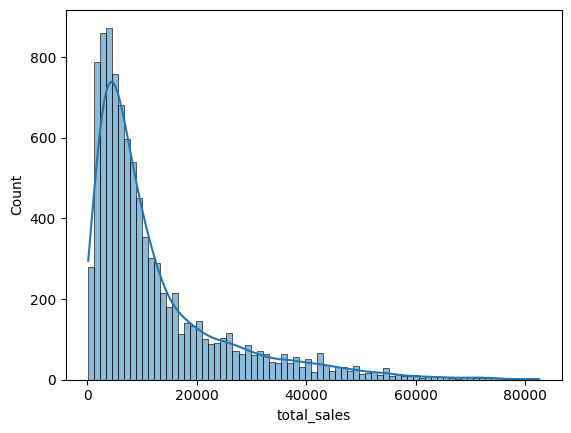

In [30]:
sns.histplot(df["total_sales"], kde = True)

<Axes: xlabel='total_sales'>

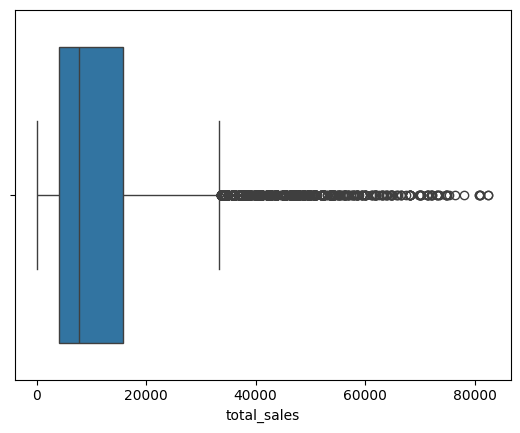

In [31]:
sns.boxplot(x=df["total_sales"])

Hay una distribución asimétrica porque habrán muchas tiendas que tengan niveles bajos o moderados. Pocas tiendas logran grandes facturaciones.

Nuestro modelo puede verse afectado por esta distribución asimetrica, debemos hacer una transformación logaritmica más adelante.

<Axes: xlabel='total_sales', ylabel='Count'>

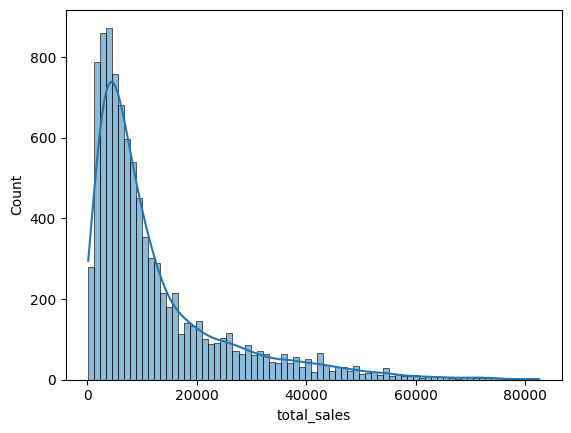

In [32]:
sns.histplot(df["total_sales"], kde = True)

CREACION DE LOS DATASETS POR RETAILER

In [33]:
df["retailer"].value_counts()

retailer
Foot Locker      2630
West Gear        2372
Sports Direct    2030
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

In [34]:
df_footlocker = df[df["retailer"] == "Foot Locker"]
df_westgear = df[df["retailer"] == "West Gear"]
df_sportsdirect = df[df["retailer"] == "Sports Direct"]
df_kohls = df[df["retailer"] == "Kohl's"]
df_amazon = df[df["retailer"] == "Amazon"]
df_walmart = df[df["retailer"] == "Walmart"]

In [54]:
# Comentamos el código para no ejecutarlo de nuevo, pero este sería el dataset limpiado
df.to_csv("../data/adidas_sales_cleaned_last4.csv", index=False)

In [55]:
print("---Foot Locker---")
print(df_footlocker["total_sales"].describe())
print("---West Gear---")
print(df_westgear["total_sales"].describe())
print("---Sports Direct---")
print(df_sportsdirect["total_sales"].describe())
print("---Kohl's---")
print(df_kohls["total_sales"].describe())
print("---Amazon---")
print(df_amazon["total_sales"].describe())
print("---Walmart---")
print(df_walmart["total_sales"].describe())


---Foot Locker---
count     2630.000000
mean     11028.496198
std      12328.590997
min        160.000000
25%       3185.250000
50%       6689.500000
75%      13500.000000
max      76500.000000
Name: total_sales, dtype: float64
---West Gear---
count     2372.000000
mean     13624.708263
std      14074.800399
min        203.000000
25%       4263.750000
50%       8537.000000
75%      16855.500000
max      82500.000000
Name: total_sales, dtype: float64
---Sports Direct---
count     2030.000000
mean     12097.535468
std      11682.592391
min        528.000000
25%       4224.000000
50%       7522.000000
75%      15750.000000
max      69875.000000
Name: total_sales, dtype: float64
---Kohl's---
count     1030.000000
mean     13118.886408
std      11122.789865
min        520.000000
25%       5336.750000
50%       8243.000000
75%      20000.000000
max      52000.000000
Name: total_sales, dtype: float64
---Amazon---
count      949.000000
mean     10639.606955
std       9957.157975
min        416

In [56]:
# df_footlocker.to_csv("../data/adidas_sales_footlocker.csv", index=False)
# df_westgear.to_csv("../data/adidas_sales_westgear.csv", index=False)
# df_sportsdirect.to_csv("../data/adidas_sales_sportsdirect.csv", index=False)
# df_kohls.to_csv("../data/adidas_sales_kohls.csv", index=False)
# df_amazon.to_csv("../data/adidas_sales_amazon.csv", index=False)
# df_walmart.to_csv("../data/adidas_sales_walmart.csv", index=False)

# ✅ Step 4: Train y Test.


In [57]:
df_cleaned = pd.read_csv("../data/adidas_sales_cleaned_last4.csv", parse_dates=["invoice_date"], index_col=False)

In [58]:
df_cleaned

,retailer,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales
0,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0
1,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0
2,Foot Locker,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0
3,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0
4,Foot Locker,2020-01-01,Northeast,New York,New York,Men's Street Footwear,47.0,336,15792.0
...,...,...,...,...,...,...,...,...,...
9632,Foot Locker,2021-12-31,Northeast,Pennsylvania,Philadelphia,Men's Apparel,63.0,47,2961.0
9633,Amazon,2021-12-31,Northeast,Maine,Portland,Men's Apparel,55.0,125,6875.0
9634,Foot Locker,2021-12-31,Northeast,Pennsylvania,Philadelphia,Men's Apparel,46.0,56,2576.0
9635,Amazon,2021-12-31,Northeast,Maine,Portland,Men's Apparel,52.0,36,1872.0


In [59]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9637 entries, 0 to 9636
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9637 non-null   object        
 1   invoice_date    9637 non-null   datetime64[ns]
 2   region          9637 non-null   object        
 3   state           9637 non-null   object        
 4   city            9637 non-null   object        
 5   product         9637 non-null   object        
 6   price_per_unit  9637 non-null   float64       
 7   units_sold      9637 non-null   int64         
 8   total_sales     9637 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 677.7+ KB


A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS

In [60]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en train y test
X = df_cleaned.drop(columns=['total_sales', "units_sold"])
y = df_cleaned['total_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

----------------

B. PREVENCIÓN A LA ROTURA DE STOCK Y MEJORA EN COSTES

# ✅ Step 5: Mini Eda + Preparación del dataset


A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS

In [61]:
X_train.columns

Index(['retailer', 'invoice_date', 'region', 'state', 'city', 'product',
       'price_per_unit'],
      dtype='object')

In [62]:
X_train['month'] = X_train['invoice_date'].dt.month
X_train['day_of_week'] = X_train['invoice_date'].dt.dayofweek  # Lunes=0, Domingo=6
#X_train["quarter"] = X_train["invoice_date"].dt.quarter


X_test['month'] = X_test['invoice_date'].dt.month
X_test['day_of_week'] = X_test['invoice_date'].dt.dayofweek  # Lunes=0, Domingo=6
#X_test["quarter"] = X_test["invoice_date"].dt.quarter

In [63]:
X_train = X_train.drop(columns=['invoice_date', 'city', "units_sold"], errors="ignore")
X_test = X_test.drop(columns=['invoice_date', 'city', "units_sold"], errors="ignore")

In [64]:
X_train

,retailer,region,state,product,price_per_unit,month,day_of_week
485,West Gear,Southeast,Florida,Men's Apparel,60.0,4,4
6472,Sports Direct,South,Texas,Men's Apparel,26.0,8,6
1222,Foot Locker,Midwest,Minnesota,Men's Apparel,35.0,12,1
5608,West Gear,Northeast,New York,Women's Apparel,66.0,7,3
2855,Kohl's,Midwest,Montana,Women's Apparel,55.0,3,1
...,...,...,...,...,...,...,...
5734,Kohl's,Midwest,Kansas,Men's Athletic Footwear,49.0,7,0
5191,Sports Direct,Midwest,Michigan,Women's Street Footwear,41.0,6,3
5390,West Gear,West,Oregon,Men's Apparel,86.0,6,3
860,Walmart,South,Texas,Men's Apparel,45.0,8,6


In [65]:
categorical_features = ['retailer', 'region', 'state', 'product', 'day_of_week', "month"]
numeric_features = ['price_per_unit']

In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
preprocessor = ColumnTransformer(
     transformers=[
      ("num", "passthrough", numeric_features),
      ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)])



In [136]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [137]:
ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)
ohe_columns_clean = np.char.replace(ohe_columns.astype(str), ' ', '_')
all_columns_clean = np.concatenate([numeric_features, ohe_columns_clean])

In [138]:
X_train_df = pd.DataFrame(X_train_preprocessed, columns=all_columns_clean, index=X_train.index)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=all_columns_clean, index=X_test.index)

In [70]:
X_train_df

,price_per_unit,retailer_Amazon,retailer_Foot_Locker,retailer_Kohl's,retailer_Sports_Direct,retailer_Walmart,retailer_West_Gear,region_Midwest,region_Northeast,region_South,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
485,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6472,26.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1222,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5608,66.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2855,55.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,49.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5191,41.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,86.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Visualizamos nuestro target - y_train

In [71]:
y_train.describe()

count     7709.000000
mean     12378.403035
std      12626.345755
min        160.000000
25%       4080.000000
50%       7791.000000
75%      15750.000000
max      82500.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales'>

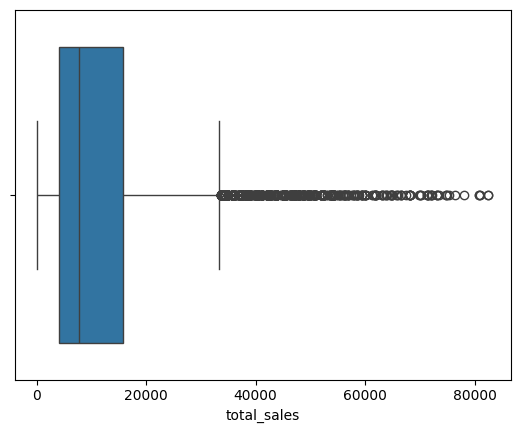

In [74]:
sns.boxplot(x=y_train)

<Axes: xlabel='total_sales', ylabel='Count'>

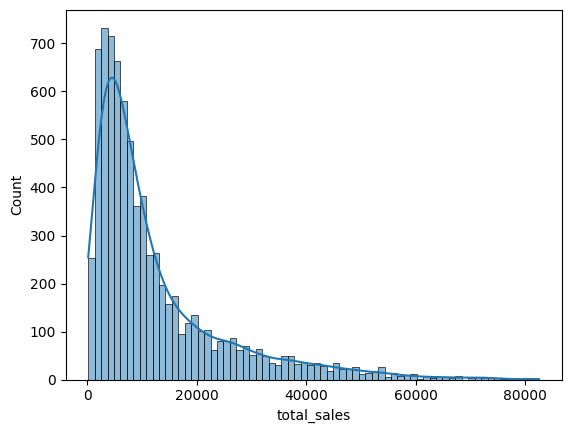

In [75]:
sns.histplot(y_train, kde = True)

In [111]:
len(y_train[y_train > 60000])

63

-------------------

In [80]:
# crea muchos valores en la mediana y puede confundir

In [77]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_no_outliers = y_train[(y_train >= lower_bound) & (y_train <= upper_bound)].median()
print(f"La mediana es de {median_no_outliers}")

y_train_imputed = y_train.copy()
y_train_imputed[(y_train < lower_bound) | (y_train > upper_bound)] = median_no_outliers

# 4. Aplica los mismos límites y mediana en y_test
y_test_imputed = y_test.copy()
y_test_imputed[(y_test < lower_bound) | (y_test > upper_bound)] = median_no_outliers

La mediana es de 7000.0


In [78]:
y_train_imputed.describe()


count     7709.000000
mean      9265.476586
std       7304.726214
min        160.000000
25%       4080.000000
50%       7000.000000
75%      12000.000000
max      33250.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales', ylabel='Count'>

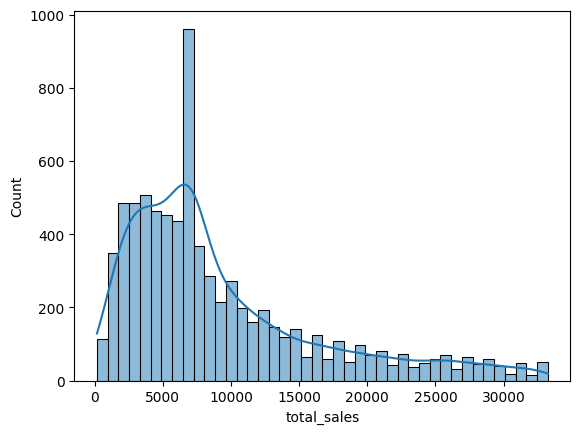

In [79]:
sns.histplot(y_train_imputed, kde = True)

----------

In [92]:
# capping / windsorizing

upper_cap = y_train.quantile(0.97)
y_train_capped = y_train.copy()
y_train_capped[y_train_capped > upper_cap] = upper_cap

y_test_capped = y_test.copy()
y_test_capped[y_test_capped > upper_cap] = upper_cap

In [93]:
y_train_capped.describe()

count     7709.000000
mean     12076.314567
std      11545.613842
min        160.000000
25%       4080.000000
50%       7791.000000
75%      15750.000000
max      46750.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales', ylabel='Count'>

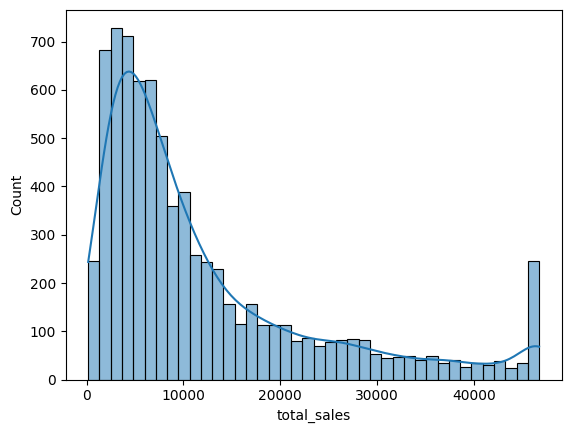

In [94]:
sns.histplot(y_train_capped, kde = True)

---------


---------------
MOMENTO NEGOCIO

- Considero que los valores que tenemos por encima de 60000 euros que son 63 filas y que representan el 0,63% del dataset vamos a eliminarlos porque generan ruido y son ventas poco frencuentes. No serian relevantes para una predicción habitual del comercio. Aun asi, esto seria algo para comentar con los jefes de equipo.

In [112]:
# eliminamos los outliers
mask_train = y_train <= 60000
X_train_filtered = X_train[mask_train]
y_train_filtered = y_train[mask_train]

In [141]:
y_train_filtered.describe()

count     7646.000000
mean     11912.671201
std      11572.410679
min        160.000000
25%       4056.000000
50%       7689.500000
75%      15125.000000
max      60000.000000
Name: total_sales, dtype: float64

In [140]:
# eliminamos los outliers de otros df
X_train_df_mask = X_train_df[mask_train]

In [118]:
from scipy.stats import boxcox

In [115]:
# box-cox transformation
from scipy.stats import boxcox
y_train_boxcox, lambda_val = boxcox(y_train_filtered)

# lambda_val es el parámetro óptimo calculado para la transformación.
print(f"Lambda óptima: {lambda_val}")

Lambda óptima: 0.05760070206033427


In [117]:
# test aplicamos el mismo boxcox que en train
y_test_boxcox = boxcox(y_test, lmbda=lambda_val)


<Axes: ylabel='Count'>

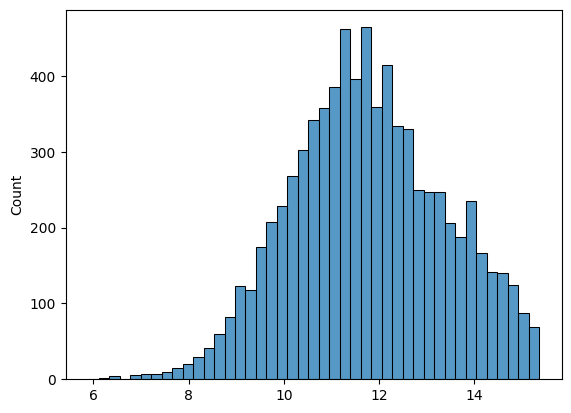

In [116]:
sns.histplot(y_train_boxcox)

Nuestro modelo puede verse afectado por esta distribución asimetrica, debemos hacer una transformación logaritmica.

In [100]:
# y_train_log = np.log1p(y_train_capped)
# y_test_log = np.log1p(y_test_capped)

In [101]:
# sns.histplot(y_train_log, kde = True)

In [122]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7709 entries, 485 to 7270
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   retailer        7709 non-null   object 
 1   region          7709 non-null   object 
 2   state           7709 non-null   object 
 3   product         7709 non-null   object 
 4   price_per_unit  7709 non-null   float64
 5   month           7709 non-null   int32  
 6   day_of_week     7709 non-null   int32  
dtypes: float64(1), int32(2), object(4)
memory usage: 421.6+ KB


In [121]:
X_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7646 entries, 485 to 7270
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   retailer        7646 non-null   object 
 1   region          7646 non-null   object 
 2   state           7646 non-null   object 
 3   product         7646 non-null   object 
 4   price_per_unit  7646 non-null   float64
 5   month           7646 non-null   int32  
 6   day_of_week     7646 non-null   int32  
dtypes: float64(1), int32(2), object(4)
memory usage: 418.1+ KB


In [123]:
y_train_filtered.describe()

count     7646.000000
mean     11912.671201
std      11572.410679
min        160.000000
25%       4056.000000
50%       7689.500000
75%      15125.000000
max      60000.000000
Name: total_sales, dtype: float64

In [ ]:
# Probamos CATBOOST
from scipy.special import inv_boxcox
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)
y_pred_boxcox_cat = cat_model.predict(X_test)
y_pred = inv_boxcox(y_pred_boxcox_cat, lambda_val)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

RMSE: 5823.3707388852345
MAE: 3259.493342577165
R2: 0.800129894231919


In [105]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,price_per_unit,62.389451
1,state,14.192299
2,product,7.790658
3,region,6.617717
4,month,3.977592
5,retailer,3.742286
6,day_of_week,1.289997


In [187]:
def rmse_in_original(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_in_original, greater_is_better=False)

In [125]:
def rmse_boxcox_inverse(y_true_boxcox, y_pred_boxcox):
    y_true_original = inv_boxcox(y_true_boxcox, lambda_val)
    y_pred_original = inv_boxcox(y_pred_boxcox, lambda_val)
    
    return np.sqrt(mean_squared_error(y_true_original, y_pred_original))

scorer = make_scorer(rmse_boxcox_inverse, greater_is_better=False)

In [126]:
param_grid = {
    "depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
    "iterations": [300, 500, 700],
    "l2_leaf_reg": [1, 3, 5]
}

grid_cat = GridSearchCV(
    cat_model,
    param_grid,
    cv=3,
    scoring=scorer,
    n_jobs=-1
)

grid_cat.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

best_model_cat = grid_cat.best_estimator_

print(f"Mejores hiperparametros: {grid_cat.best_params_}")
print(f"Mejor score RMSE: {grid_cat.best_score_}")

Mejores hiperparametros: {'depth': 3, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.5}
Mejor score RMSE: -5370.365976655319


In [128]:
print(f"Mejor MAE: {mean_absolute_error(y_test, inv_boxcox(best_model_cat.predict(X_test), lambda_val))}")

Mejor MAE: 3235.2994021627333


In [127]:
print(f"Mejor R2: {r2_score(y_test, best_model_cat.predict(X_test))}")

Mejor R2: -0.95530926403066


In [144]:
from sklearn.linear_model import LinearRegression

# Entrenar el modelo de regresión lineal
baseline_model = LinearRegression()
baseline_model.fit(X_train_df_mask, y_train_boxcox)

# Predecir en el conjunto de prueba
y_pred_boxcox_baseline = baseline_model.predict(X_test_df)

y_pred_baseline = inv_boxcox(y_pred_boxcox_baseline, lambda_val)

# Evaluar el modelo
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"RMSE: {rmse_baseline}")
print(f"MAE: {mae_baseline}")
print(f"R2: {r2_baseline}")

RMSE: 9548.563064652424
MAE: 6533.532295919779
R2: 0.4626280365089611


In [145]:
# rf

from sklearn.ensemble import RandomForestRegressor

# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_df_mask, y_train_boxcox)

# Predecir en el conjunto de prueba
y_pred_boxcox_rf = rf_model.predict(X_test_df)
y_pred_rf = inv_boxcox(y_pred_boxcox_rf, lambda_val)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf}")
print(f"Random Forest - MAE: {mae_rf}")
print(f"Random Forest - R2: {r2_rf}")

Random Forest - RMSE: 6367.61176213551
Random Forest - MAE: 3481.9562031827218
Random Forest - R2: 0.7610251954558832


In [142]:
# xgboost

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_df_mask, y_train_boxcox)

y_pred_boxcox_xgb = xgb_model.predict(X_test_df)
y_pred_xgb = inv_boxcox(y_pred_boxcox_xgb, lambda_val)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"XGBoost - MAE: {mae_xgb}")
print(f"XGBoost - R2: {r2_xgb}")




XGBoost - RMSE: 6881.036112354312
XGBoost - MAE: 3951.1819072739218
XGBoost - R2: 0.7209341868703403


In [150]:
print(f"--- Baseline LR ---")
print(f"RMSE: {rmse_baseline:.2f}, MAE: {mae_baseline:.2f}, R²: {r2_baseline:.4f}")

print(f"--- XGBoost ---")
print(f"RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.4f}")

print(f"--- Random Forest ---")
print(f"RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.4f}")

print(f"--- CatBoost ---")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

print(f"--- CatBoost GridSearch ---")
print(f"RMSE: {grid_cat.best_score_:.2f}, MAE: {mean_absolute_error(y_test, inv_boxcox(best_model_cat.predict(X_test), lambda_val)):.2f}, R²: {r2_score(y_test, best_model_cat.predict(X_test)):.4f}")

--- Baseline LR ---
RMSE: 9548.56, MAE: 6533.53, R²: 0.4626
--- XGBoost ---
RMSE: 6881.04, MAE: 3951.18, R²: 0.7209
--- Random Forest ---
RMSE: 6367.61, MAE: 3481.96, R²: 0.7610
--- CatBoost ---
RMSE: 5823.37, MAE: 3259.49, R²: 0.8001
--- CatBoost GridSearch ---
RMSE: -5370.37, MAE: 3235.30, R²: -0.9553


In [193]:
from sklearn.neural_network import MLPRegressor

# Entrenar el modelo de red neuronal
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train_preprocessed, y_train)

# Predecir en el conjunto de prueba
y_pred_nn = nn_model.predict(X_test_preprocessed)

# Evaluar el modelo
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MSE: {mse_nn}, R2: {r2_nn}")

Neural Network - MSE: 75812394.13854788, R2: 0.44762754451363584


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [194]:
X_train_preprocessed

array([[50.,  0.,  1., ...,  0.,  1.,  0.],
       [65.,  0.,  0., ...,  1.,  0.,  0.],
       [40.,  0.,  1., ...,  0.,  1.,  0.],
       ...,
       [64.,  0.,  1., ...,  0.,  0.,  0.],
       [29.,  0.,  0., ...,  0.,  0.,  0.],
       [23.,  0.,  0., ...,  0.,  0.,  0.]])

In [195]:
def rmse_in_original(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_in_original, greater_is_better=False)

In [196]:
from sklearn.model_selection import GridSearchCV

# Definir la cuadrícula de hiperparámetros para XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.2, 0.3],
    'max_depth': [4, 5, 6]
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring=rmse_scorer)
grid_search.fit(X_train_preprocessed, y_train_log)

best_model_xgb = grid_search.best_estimator_

# Mejores hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Predecir con el mejor modelo
y_pred_log_grid_xgb = grid_search.predict(X_test_preprocessed)
y_pred_grid_xgb = np.expm1(y_pred_log_grid_xgb)

# Evaluar el modelo
mse_grid_xgb = mean_squared_error(y_test, y_pred_grid_xgb)
rmse_grid_xgb = np.sqrt(mse_grid_xgb)
mae_grid_xgb = mean_absolute_error(y_test, y_pred_grid_xgb)
r2_grid = r2_score(y_test, y_pred_grid_xgb)

print(f"XGBoost (GridSearch)")
print(f"RMSE: {rmse_grid_xgb}")
print(f"MAE: {mae_grid_xgb}")
print(f"R2: {r2_grid}")

Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
XGBoost (GridSearch)
RMSE: 5189.255425753662
MAE: 3018.4724640259874
R2: 0.8037986919797049


In [197]:
# RF Hiperparametros

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_preprocessed, y_train_log)
best_model_rf = grid_search.best_estimator_

# Mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Predecir en el conjunto de prueba (en escala logarítmica)
y_pred_log_grid_rf = grid_search.predict(X_test_preprocessed)
y_pred_grid_rf = np.expm1(y_pred_log_grid_rf)

# Evaluar el modelo
mse_grid_rf = mean_squared_error(y_test, y_pred_grid_rf)
rmse_grid_rf = np.sqrt(mse_grid_rf)
mae_grid_rf = mean_absolute_error(y_test, y_pred_grid_rf)
r2_grid_rf = r2_score(y_test, y_pred_grid_rf)

print(f"Random Forest (GridSearch)")
print(f"RMSE: {rmse_grid_rf}")
print(f"MAE: {mae_grid_rf}")
print(f"R2: {r2_grid_rf}")


Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest (GridSearch)
RMSE: 5603.382690047932
MAE: 3164.4353588317085
R2: 0.7712335301431235


In [198]:
# Cross Validation para RF

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

rmse_scorer = make_scorer(rmse_in_original, greater_is_better=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    best_model_rf,
    X_train_preprocessed,
    y_train_log,
    scoring=rmse_scorer,
    cv=kf,
    n_jobs=-1
)

cv_rmse_list_rf = -scores
cv_rmse_mean_rf = cv_rmse_list_rf.mean()
cv_rmse_std_rf = cv_rmse_list_rf.std()

print("CV RMSE (5-fold):", cv_rmse_list_rf)
print("Mean CV RMSE:", cv_rmse_mean_rf, "Std:", cv_rmse_std_rf)



CV RMSE (5-fold): [5847.43806264 5931.13144903 6099.97347544 5589.10307715 5825.05479773]
Mean CV RMSE: 5858.540172399286 Std: 165.77117283442215


In [199]:
# Cross Validation para XGB

rmse_scorer = make_scorer(rmse_in_original, greater_is_better=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    best_model_xgb,
    X_train_preprocessed,
    y_train_log,
    scoring=rmse_scorer,
    cv=kf,
    n_jobs=-1
)

cv_rmse_list_xgb = -scores
cv_rmse_mean_xgb = cv_rmse_list_xgb.mean()
cv_rmse_std_xgb = cv_rmse_list_xgb.std()

print("CV RMSE (5-fold):", cv_rmse_list_xgb)
print("Mean CV RMSE:", cv_rmse_mean_xgb, "Std:", cv_rmse_std_xgb)



CV RMSE (5-fold): [4968.30422797 5656.51715872 5427.97815015 5060.0048171  5292.1326314 ]
Mean CV RMSE: 5280.98739706664 Std: 248.73968903908096


In [200]:
# Comparamos lo obtenido en Grid vs CV de ambos modelos

print(f"--- Random Forest ---")
print(f"GridSearch RMSE: {rmse_grid_rf:.2f}")
print(f"CV RMSE: {cv_rmse_mean_rf:.2f}")

print(f"--- XGBoost ---")
print(f"GridSearch RMSE: {rmse_grid_xgb:.2f}")
print(f"CV RMSE: {cv_rmse_mean_xgb:.2f}")

--- Random Forest ---
GridSearch RMSE: 5603.38
CV RMSE: 5858.54
--- XGBoost ---
GridSearch RMSE: 5189.26
CV RMSE: 5280.99


In [201]:
import joblib

# joblib.dump(best_model_xgb, "../models/xgb_model.pkl")

In [ ]:
## de aqui para arriba

# ✅ Step 6: Selección e instanciación de modelos. Baseline.


Baseline:

In [ ]:
y_pred_log_xgb = xgb_model.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)

In [ ]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"XGBoost - MAE: {mae_xgb}")
print(f"XGBoost - R2: {r2_xgb}")

XGBoost - RMSE: 5298.727224094555
XGBoost - MAE: 3050.661547870447
XGBoost - R2: 0.8304386438778383


In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train_log)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred_log = rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log)

In [ ]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf}")
print(f"Random Forest - MAE: {mae_rf}")
print(f"Random Forest - R2: {r2_rf}")

Random Forest - RMSE: 5781.170190134396
Random Forest - MAE: 3134.29563672731
Random Forest - R2: 0.7981562691884041


In [ ]:
print(f"--- Baseline LR ---")
print(f"RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.4f}")

print(f"--- XGBoost ---")
print(f"RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.4f}")

print(f"--- Random Forest ---")
print(f"RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.4f}")

--- Baseline LR ---
RMSE: 9460.38, MAE: 6450.23, R²: 0.4595
--- XGBoost ---
RMSE: 5298.73, MAE: 3050.66, R²: 0.8304
--- Random Forest ---
RMSE: 5781.17, MAE: 3134.30, R²: 0.7982


- Vamos a comprobar si hay sobreajuste

In [ ]:
# Modelo entrenado, por ejemplo, rf_model
# 1) Predicciones en train
y_pred_train_log = rf.predict(X_train)
y_pred_train = np.expm1(y_pred_train_log)  # volver a escala original
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print(f"Train - RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")

# 2) Predicciones en test
y_pred_test_log = rf.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Test  - RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}")


Train - RMSE: 3060.95, MAE: 1646.63
Test  - RMSE: 5781.17, MAE: 3134.30


In [ ]:
def rmse_in_original(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_in_original, greater_is_better=False)

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 3 ,5, 8],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=2,
)

grid_rf.fit(X_train, y_train_log)
print("Mejores parámetros:", grid_rf.best_params_)
print("Mejor score:", grid_rf.best_score_)
rmse_cv_best_rf = -grid_rf.best_score_
print(f"Mejor RMSE en CV escala original: {rmse_cv_best_rf:.2f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
276 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\skl

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor score: -8909.363494742267
Mejor RMSE en CV escala original: 8909.36


In [ ]:
best_rf = grid_rf.best_estimator_

# Predecir en escala log
y_pred_log = best_rf.predict(X_test)

# Convertir a original
y_pred = np.expm1(y_pred_log)

# Mides el error en la escala original

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test  = mean_absolute_error(y_test, y_pred)
r2_test   = r2_score(y_test, y_pred)

print(f"RF en test con CV - RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.3f}")


RF en test con CV - RMSE: 8812.65, MAE: 5318.45, R²: 0.531


In [ ]:
scores = cross_val_score(
    rf, 
    X_train, 
    y_train_log, 
    scoring=rmse_scorer,
    cv=3
)

# Se obtiene un array de valores negativos
scores_rmse = -scores  
print("RMSE en CV:", scores_rmse)
print("Media RMSE:", scores_rmse.mean())

RMSE en CV: [5799.72498295 6187.24183298 5885.48897122]
Media RMSE: 5957.485262383864


In [ ]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [1.0, 0.8],
    'colsample_bytree': [1.0, 0.8]
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid_xgb.fit(X_train, y_train)
print("Mejores parámetros:", grid_xgb.best_params_)
print("Mejor score (neg RMSE):", grid_xgb.best_score_)
best_rmse = -grid_xgb.best_score_
print(f"Mejor RMSE (positivo) en CV: {best_rmse:.2f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}
Mejor score (neg RMSE): nan
Mejor RMSE (positivo) en CV: nan


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


<function list.index(value, start=0, stop=9223372036854775807, /)>

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3056\3207993305.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.importance[:20], y=feature_importances.feature[:20], palette="viridis")


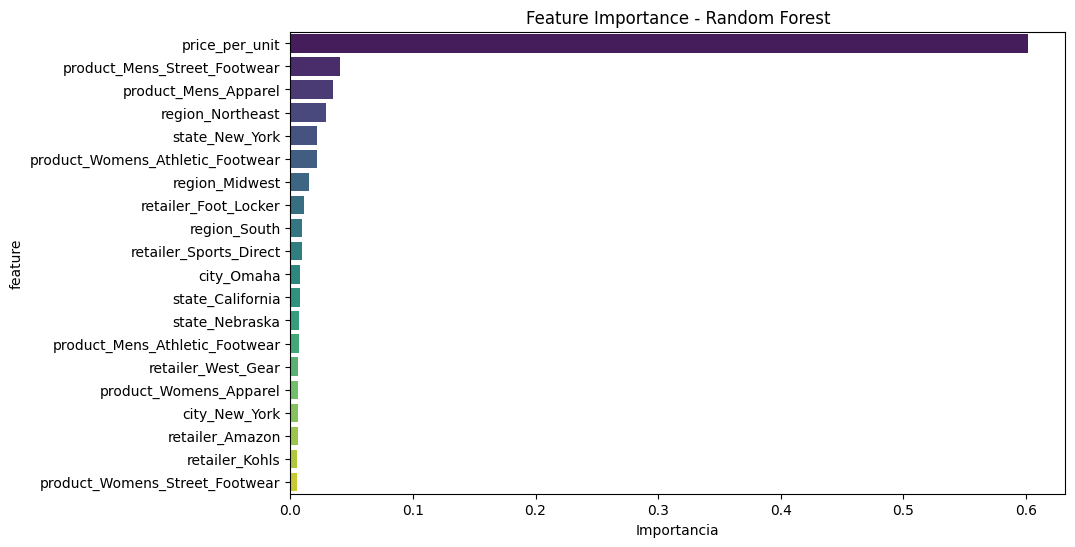

In [ ]:
feature_importances = pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_})
feature_importances = feature_importances.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance[:20], y=feature_importances.feature[:20], palette="viridis")
plt.xlabel("Importancia")
plt.title("Feature Importance - Random Forest")
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3056\1807826985.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_xgb.importance[:20], y=feature_importances_xgb.feature[:20], palette="coolwarm")


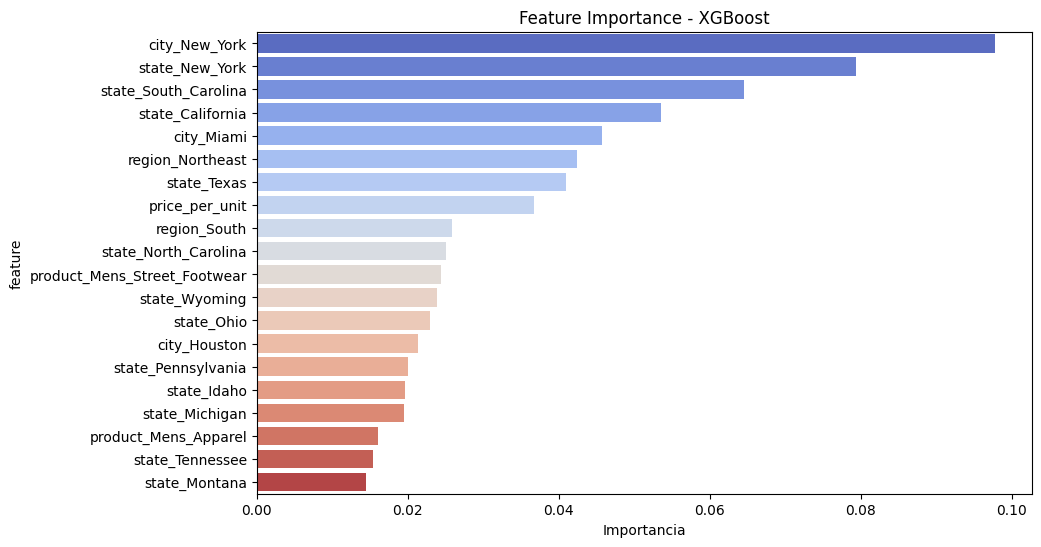

In [ ]:
# Entrenar un modelo XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Importancia de features
feature_importances_xgb = pd.DataFrame({'feature': X_train.columns, 'importance': xgb.feature_importances_})
feature_importances_xgb = feature_importances_xgb.sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_xgb.importance[:20], y=feature_importances_xgb.feature[:20], palette="coolwarm")
plt.xlabel("Importancia")
plt.title("Feature Importance - XGBoost")
plt.show()


# ✅ Step 6: Selección e instanciación de modelos. Baseline.


# ✅ Step 8: Comparación de modelos.


# ✅ Step 9: Selección del modelo - Optimización de hiperparámetros.


# ✅ Step 10: Evaluación contra test.


# ✅ Step 11: Análisis de errores.


# ✅ Step 12: Persistencia del modelo en disco.